<a href="https://colab.research.google.com/github/rishicarter/Tensorflow_fundamentals/blob/main/08_Skimlit_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-8f90b03a-6491-132c-ef39-0ff5b1e244c4)


# Get data

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
Checking out files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign'

In [4]:
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]

filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signtest.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signdev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signtrain.txt']

# Imports and functions

In [5]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-08-02 15:53:09--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-02 15:53:09 (86.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from helper_functions import calculate_results
import random


from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding


In [7]:
#Functions
def get_lines(filename):

  with open(filename,mode='r') as f:
    return f.readlines()

def preprocess_text_with_linenums(filename):
  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith('###'):
      abstract_id=line
      abstract_lines=""
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data={}
        target_text_split=abstract_line.split('\t')
        line_data['target']=target_text_split[0]
        line_data['text']=target_text_split[1].lower()
        line_data['line_number']=abstract_line_number
        line_data['total_lines']=len(abstract_line_split)-1
        abstract_samples.append(line_data)
    else:
      abstract_lines+=line
  return abstract_samples

def split_chars(text):
  return " ".join(list(text))

#Preprocess

In [8]:
train_lines = get_lines(data_dir+'/train.txt')
train_lines[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [9]:
%%time
train_samples = preprocess_text_with_linenums(data_dir+'/train.txt')
val_samples = preprocess_text_with_linenums(data_dir+'/dev.txt')
test_samples = preprocess_text_with_linenums(data_dir+'/test.txt')

CPU times: user 695 ms, sys: 111 ms, total: 806 ms
Wall time: 1.16 s


In [10]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [11]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [12]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

In [13]:
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

# Numeric Labels

In [14]:
from sklearn.preprocessing import OneHotEncoder
one_hot = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot.transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot.transform(test_df['target'].to_numpy().reshape(-1,1))

In [15]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

In [16]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

# Model 0: baseline

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [37]:
model_0.score(val_sentences, val_labels_encoded)

0.7218323844829869

In [38]:
baseline_results=model_0.predict(val_sentences)

In [39]:
calculate_results(val_labels_encoded,
                  baseline_results)

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

# Preprocess for tensor batches

In [17]:
# sentence length
sent_lens = [len(sent.split()) for sent in train_sentences]
avg_slen = np.mean(sent_lens)
avg_slen

26.338269273494777

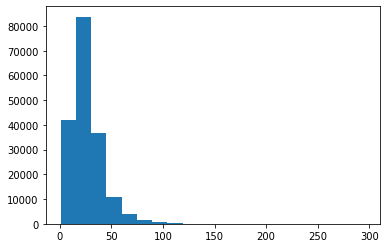

In [18]:
plt.hist(sent_lens, bins=20);

In [19]:
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [20]:
max_tokens = 68000
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length = output_seq_len)

In [21]:
text_vectorizer.adapt(train_sentences)

In [22]:
vocab=text_vectorizer.get_vocabulary()

In [23]:
token_embed = layers.Embedding(input_dim=len(vocab),
                               output_dim=128,
                               mask_zero=True,
                               name='token_embedding')

In [24]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

In [25]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Model 1 : Conv1d

In [27]:
# Create 1D convolutional model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
# Get summary of Conv1D model
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [28]:
hist_1 = model_1.fit(train_dataset,
                     steps_per_epoch=int(0.1*len(train_dataset)),
                     epochs=3,
                     validation_data=val_dataset,
                     validation_steps=int(0.1*len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 17s 9ms/step - loss: 0.9231 - accuracy: 0.6342 - val_loss: 0.6861 - val_accuracy: 0.7424
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6532 - accuracy: 0.7618 - val_loss: 0.6228 - val_accuracy: 0.7723
Epoch 3/3
562/562 [==============================] - 5s 10ms/step - loss: 0.6142 - accuracy: 0.7781 - val_loss: 0.5922 - val_accuracy: 0.7842


In [29]:
model_1.evaluate(val_dataset)

945/945 [==============================] - 5s 6ms/step - loss: 0.5934 - accuracy: 0.7864


[0.5934426784515381, 0.7864424586296082]

In [32]:
model_1_predprobs = model_1.predict(val_dataset)
model_1_preds=tf.argmax(model_1_predprobs, axis=1)
mode_1_results=calculate_results(val_labels_encoded,model_1_preds)
mode_1_results

{'accuracy': 78.64424731894611,
 'f1': 0.783976193795473,
 'precision': 0.7831827052389839,
 'recall': 0.7864424731894611}

#Model_1: feature extraction using token embeddings


https://tfhub.dev/google/universal-sentence-encoder/4

In [33]:
import tensorflow_hub as hub
embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                 trainable=False,
                                 name='universal_sentence_encoder')

In [34]:
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding=embedding_layer(inputs)
x=layers.Dense(128, activation='relu')(pretrained_embedding)
outputs=layers.Dense(num_classes,activation='softmax')(x)
model_2=tf.keras.Model(inputs,outputs)

model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [35]:
hist_2=model_2.fit(train_dataset,
                   epochs=3,
                   steps_per_epoch=int(0.1*len(train_dataset)),
                   validation_data=val_dataset,
                   validation_steps=int(0.1*len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 19s 21ms/step - loss: 0.9158 - accuracy: 0.6524 - val_loss: 0.7927 - val_accuracy: 0.6895
Epoch 2/3
562/562 [==============================] - 9s 17ms/step - loss: 0.7657 - accuracy: 0.7025 - val_loss: 0.7506 - val_accuracy: 0.7021
Epoch 3/3
562/562 [==============================] - 11s 19ms/step - loss: 0.7498 - accuracy: 0.7132 - val_loss: 0.7359 - val_accuracy: 0.7128


In [36]:
model_2.evaluate(val_dataset)

945/945 [==============================] - 17s 18ms/step - loss: 0.7399 - accuracy: 0.7144


[0.7398782968521118, 0.7143518924713135]

In [37]:
model_2_preds = np.argmax(model_2.predict(val_dataset),axis=1)
model_2_results = calculate_results(val_labels_encoded,model_2_preds)
model_2_results

{'accuracy': 71.43519131470939,
 'f1': 0.7114088463962585,
 'precision': 0.7141860709709087,
 'recall': 0.7143519131470939}

# Preprocess for character embedding layer

In [26]:
train_chars=[split_chars(sent) for sent in train_sentences]
val_chars=[split_chars(sent) for sent in val_sentences]
test_chars=[split_chars(sent) for sent in test_sentences]

In [27]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [28]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation

In [29]:
NUM_CHAR_TOKENS = len(alphabet)+2
char_vectorizer=TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                  output_sequence_length=output_seq_char_len,
                                  name='char_vectorizer')
char_vectorizer.adapt(train_chars)

In [30]:
char_vocab = char_vectorizer.get_vocabulary()

In [31]:
char_embedding_layer = Embedding(input_dim=len(char_vocab),
                                 output_dim=25,
                                 mask_zero=True,
                                 name='embed_char')

In [32]:
train_dataset2 = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot))
val_dataset2 = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot))
test_dataset2 = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot))

train_dataset2 = train_dataset2.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset2 = val_dataset2.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset2 = test_dataset2.batch(32).prefetch(tf.data.AUTOTUNE)

# Model 3 : Character embedding

In [50]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
charvector= char_vectorizer(inputs)
char_embedding = char_embedding_layer(charvector)
x=layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(char_embedding)
x=layers.GlobalMaxPooling1D()(x)
outputs=layers.Dense(num_classes, activation='softmax')(x)
model_3=tf.keras.Model(inputs,outputs)

model_3.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
model_3.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 embed_char (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_2 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_4 (Dense)             (None, 5)                 325 

In [51]:
hist_3=model_3.fit(train_dataset2,
                   steps_per_epoch=int(0.1*len(train_dataset2)),
                   epochs=3,
                   validation_data = val_dataset2,
                   validation_steps=int(0.1*len(val_dataset2)))

Epoch 1/3
562/562 [==============================] - 6s 9ms/step - loss: 1.2590 - accuracy: 0.4801 - val_loss: 1.1136 - val_accuracy: 0.5552
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 1.0830 - accuracy: 0.5546 - val_loss: 1.0147 - val_accuracy: 0.5871
Epoch 3/3
562/562 [==============================] - 5s 10ms/step - loss: 0.9941 - accuracy: 0.6040 - val_loss: 0.9383 - val_accuracy: 0.6346


In [52]:
model_3.evaluate(val_dataset2)

945/945 [==============================] - 5s 5ms/step - loss: 0.9588 - accuracy: 0.6235


[0.958838939666748, 0.6235270500183105]

In [53]:
model_3_preds = np.argmax(model_3.predict(val_dataset2),axis=1)

In [55]:
model_3_results=calculate_results(val_labels_encoded,model_3_preds)
model_3_results

{'accuracy': 62.35270753343043,
 'f1': 0.6150103460576405,
 'precision': 0.6296230343102777,
 'recall': 0.6235270753343043}

# Model4: Combining pretrained token embeddings + character embeddings

In [42]:
token_inputs = layers.Input(shape=[], dtype=tf.string)
token_embeddings = embedding_layer(token_inputs)
token_output = layers.Dense(128,activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,outputs=token_output)

char_inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vector=char_vectorizer(char_inputs)
char_embedding=char_embedding_layer(char_vector)
char_bilstm = layers.Bidirectional(layers.LSTM(24))(char_embedding)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bilstm)

token_char_concat = layers.Concatenate(name='hybrid')([token_model.output,
                                                       char_model.output])

combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation='relu')(final_dropout)

model_4 = tf.keras.Model(inputs = [token_model.inputs, char_model.inputs],
                         outputs=output_layer)

model_4.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
model_4.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['input_9[0][0]']                
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['input_8[0][0]']         

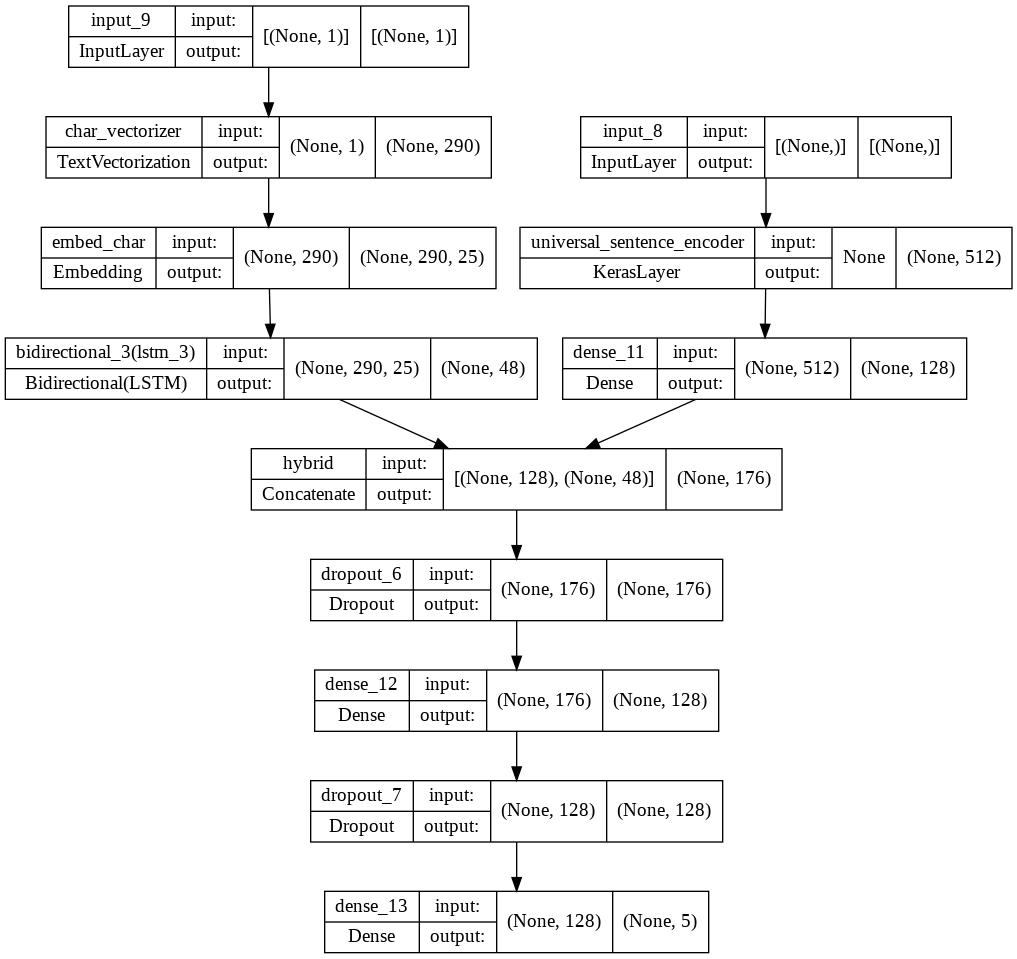

In [43]:
tf.keras.utils.plot_model(model_4,show_shapes=True)

In [44]:
hybrid_train_data = tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))
hybrid_train_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
hybrid_train_dataset = tf.data.Dataset.zip((hybrid_train_data,hybrid_train_labels))
hybrid_train_dataset = hybrid_train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

hybrid_val_data = tf.data.Dataset.from_tensor_slices((val_sentences,val_chars))
hybrid_val_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
hybrid_val_dataset = tf.data.Dataset.zip((hybrid_val_data,hybrid_val_labels))
hybrid_val_dataset = hybrid_val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

hybrid_test_data = tf.data.Dataset.from_tensor_slices((test_sentences,test_chars))
hybrid_test_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
hybrid_test_dataset = tf.data.Dataset.zip((hybrid_test_data,hybrid_test_labels))
hybrid_test_dataset=hybrid_test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [45]:
hist_4 = model_4.fit(hybrid_train_dataset,steps_per_epoch=int(0.1*len(hybrid_train_dataset)),
                     epochs=3,
                     validation_data=hybrid_val_dataset,
                     validation_steps=int(0.1*len(hybrid_val_dataset)))

Epoch 1/3
562/562 [==============================] - 65s 84ms/step - loss: 1.5660 - accuracy: 0.4727 - val_loss: 1.0357 - val_accuracy: 0.6097
Epoch 2/3
562/562 [==============================] - 44s 78ms/step - loss: 1.2208 - accuracy: 0.5654 - val_loss: 0.9673 - val_accuracy: 0.6230
Epoch 3/3
562/562 [==============================] - 36s 65ms/step - loss: 1.2166 - accuracy: 0.5802 - val_loss: 0.9465 - val_accuracy: 0.6237


In [47]:
model_4_preds=tf.argmax(model_4.predict(hybrid_val_dataset),axis=1)
model_4_results = calculate_results(val_labels_encoded,model_4_preds)
model_4_results

{'accuracy': 63.41188931550378,
 'f1': 0.5924572124693547,
 'precision': 0.683095392970885,
 'recall': 0.6341188931550378}

# Positional embeddings

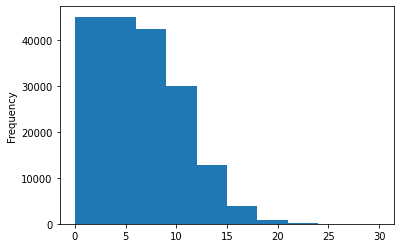

In [51]:
train_df.line_number.plot.hist()

In [52]:
train_line_numbers = tf.one_hot(train_df['line_number'].to_numpy(),depth=15)
val_line_numbers=tf.one_hot(val_df['line_number'].to_numpy(),depth=15)
test_line_numbers=tf.one_hot(test_df['line_number'].to_numpy(),depth=15)

In [ ]:
train_df.total_lines.value_counts()

In [54]:
train_lines = tf.one_hot(train_df['total_lines'].to_numpy(),depth=20)
val_lines = tf.one_hot(val_df['total_lines'].to_numpy(),depth=20)
test_lines = tf.one_hot(test_df['total_lines'].to_numpy(),depth=20)

# Model 5: text+char+positional embedding

In [57]:
token_input = layers.Input(shape=[], dtype=tf.string)
token_embed = embedding_layer(token_input)
token_output=layers.Dense(128,activation='relu')(token_embed)
token_model = tf.keras.Model(token_input,
                             token_output)

char_input=layers.Input(shape=(1,), dtype=tf.string)
char_vector=char_vectorizer(char_input)
char_embed=char_embedding_layer(char_vector)
char_bilstm=layers.Bidirectional(layers.LSTM(24))(char_embed)
# char_output = layers.Dense(128,activation='relu')(char_bilstm)
char_model = tf.keras.Model(inputs=char_input,
                            outputs=char_bilstm)

linenum_input = layers.Input(shape=(15,),dtype=tf.float32)
x=layers.Dense(32,activation='relu')(linenum_input)
linenum_model = tf.keras.Model(linenum_input,x)

totlines_input = layers.Input(shape=(20), dtype=tf.float32)
y=layers.Dense(32,activation='relu')(totlines_input)
totallines_model=tf.keras.Model(totlines_input,y)

combined_embedding = layers.Concatenate()([token_model.output,char_model.output])
z=layers.Dense(256,activation='relu')(combined_embedding)
z=layers.Dropout(0.5)(z)

tribrid_embedding = layers.Concatenate()([linenum_model.output,
                                          totallines_model.output,z])

output_layer = layers.Dense(num_classes,activation='softmax')(tribrid_embedding)

model_5 = tf.keras.Model(inputs = [linenum_model.input,
                                   totallines_model.input,
                                   token_model.input,
                                   char_model.input],
                         outputs=output_layer)

model_5.summary()

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_18 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['input_19[0][0]']               
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['input_18[0][0]']        

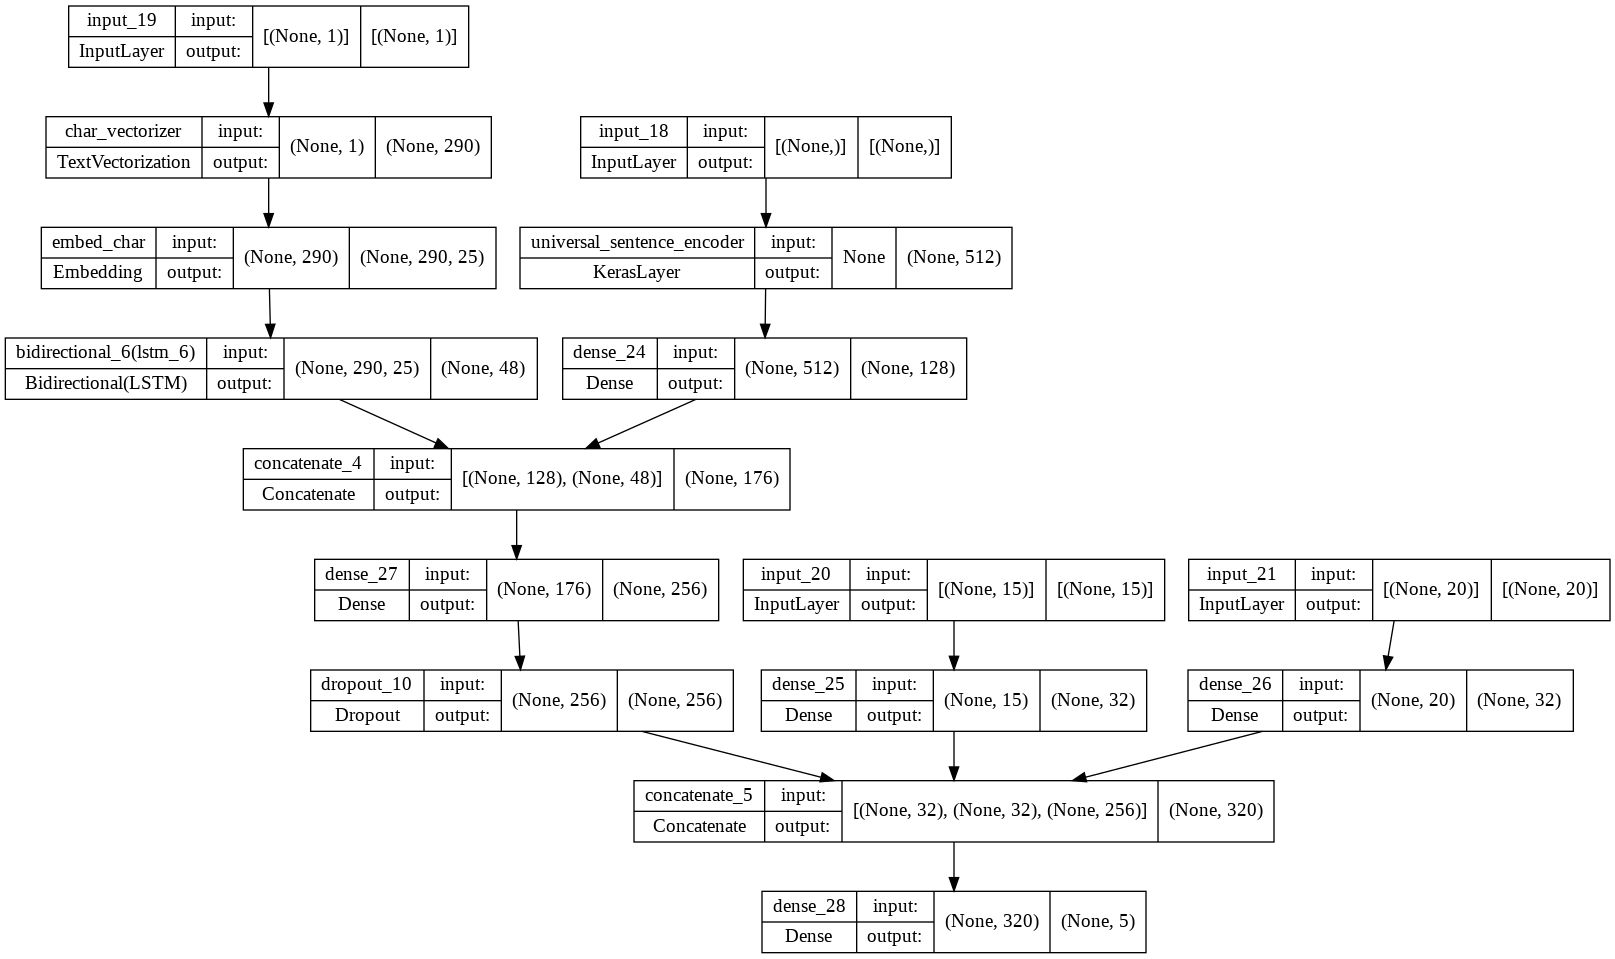

In [58]:
tf.keras.utils.plot_model(model_5, show_shapes=True)

In [59]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [60]:
tribrid_train_data = tf.data.Dataset.from_tensor_slices((train_line_numbers,
                                                         train_lines,
                                                         train_sentences,train_chars))
tribrid_train_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
tribrid_train_dataset = tf.data.Dataset.zip((tribrid_train_data,tribrid_train_labels))
tribrid_train_dataset = tribrid_train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

tribrid_val_data = tf.data.Dataset.from_tensor_slices((val_line_numbers,
                                                      val_lines,
                                                      val_sentences,val_chars))
tribrid_val_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
tribrid_val_dataset = tf.data.Dataset.zip((tribrid_val_data,tribrid_val_labels))
tribrid_val_dataset = tribrid_val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

tribrid_test_data = tf.data.Dataset.from_tensor_slices((test_line_numbers,
                                                      test_lines,
                                                      test_sentences,test_chars))
tribrid_test_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
tribrid_test_dataset = tf.data.Dataset.zip((tribrid_test_data,tribrid_test_labels))
tribrid_test_dataset=tribrid_test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [61]:
model_5.fit(tribrid_train_dataset,
            epochs=3,
            steps_per_epoch=int(0.1*len(tribrid_train_dataset)),
            validation_data=tribrid_val_dataset,
            validation_steps=int(0.1*len(tribrid_val_dataset)))

Epoch 1/3
562/562 [==============================] - 62s 87ms/step - loss: 1.0995 - accuracy: 0.7198 - val_loss: 0.9855 - val_accuracy: 0.8012
Epoch 2/3
562/562 [==============================] - 45s 79ms/step - loss: 0.9705 - accuracy: 0.8129 - val_loss: 0.9502 - val_accuracy: 0.8255
Epoch 3/3
562/562 [==============================] - 40s 71ms/step - loss: 0.9514 - accuracy: 0.8227 - val_loss: 0.9389 - val_accuracy: 0.8305


In [62]:
model_5_preds = tf.argmax(model_5.predict(tribrid_val_dataset),axis=1)
model_5_results = calculate_results(val_labels_encoded, model_5_preds)
model_5_results

{'accuracy': 83.42711505362108,
 'f1': 0.8328584363584152,
 'precision': 0.8334464143538759,
 'recall': 0.8342711505362108}